In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/ECE 49595CV/Object-Dectection-Circuit-Components'

/content/drive/MyDrive/ECE 49595CV/Object-Dectection-Circuit-Components


In [3]:
import sys
import os
import numpy as np
import cv2 as cv
import pandas as pd
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image, ImageDraw

In [ ]:
# train = pd.read_csv("data/annotations/annotations.csv")
# train.head()

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,Resistor Area,16,21,77,647,img1.jpg,410,705
1,Resistor Body,16,276,76,183,img1.jpg,410,705
2,Color,30,294,49,8,img1.jpg,410,705
3,Color,34,322,39,6,img1.jpg,410,705
4,Color,31,349,51,8,img1.jpg,410,705


In [ ]:
# coords = train[['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']].copy()
# coords.columns = ['x1', 'y1', 'w', 'h']
# coords.head()

,x1,y1,w,h
0,16,21,77,647
1,16,276,76,183
2,30,294,49,8
3,34,322,39,6
4,31,349,51,8


In [ ]:
# df = pd.concat([train, coords], axis = 1)

In [ ]:
# df["x1"] = pd.to_numeric(df["x1"])
# df["y1"] = pd.to_numeric(df["y1"])
# df["w"] = pd.to_numeric(df["w"])
# df["h"] = pd.to_numeric(df["h"])
# label_mapping = {label: idx for idx, label in enumerate(df['label_name'].unique())}
# print(label_mapping)
# df['label_idx'] = df['label_name'].map(label_mapping)

{'Resistor Area': 0, 'Resistor Body': 1, 'Color': 2}


In [ ]:
# df["x2"] = df["x1"] + df["w"]
# df["y2"] = df["y1"] + df["h"]

In [ ]:
# df.drop(['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height', 'image_width', 'image_height', 'w', 'h', 'label_name'], axis = 1, inplace = True)
# df.head()

,image_name,x1,y1,label_idx,x2,y2
0,img1.jpg,16,21,0,93,668
1,img1.jpg,16,276,1,92,459
2,img1.jpg,30,294,2,79,302
3,img1.jpg,34,322,2,73,328
4,img1.jpg,31,349,2,82,357


In [4]:
import pandas as pd
import json

with open("data/annotations/annotations.json") as f:
    data = json.load(f)

image_data = []
annotations_data = []

for image in data['images']:
    image_data.append({
        'image_id': image['id'],
        'file_name': image['file_name'],
        'width': image['width'],
        'height': image['height']
    })

for ann in data['annotations']:
    annotations_data.append({
        'image_id': ann['image_id'],
        'category_id': ann['category_id'],
        'segmentation': ann['segmentation'][0]
    })

images_df = pd.DataFrame(image_data)
annotations_df = pd.DataFrame(annotations_data)

df = pd.merge(annotations_df, images_df, on='image_id')

label_name_mapping = {cat['id']: cat['name'] for cat in data['categories']}

unique_category_ids = sorted(set(label_name_mapping.keys()))
label_index_mapping = {cat_id: idx for idx, cat_id in enumerate(unique_category_ids)}

df['label_idx'] = df['category_id'].map(label_index_mapping)

print('Label Name Mapping:', label_name_mapping)
print('Label Index Mapping:', label_index_mapping)
print(df.head())

Label Name Mapping: {1: 'Resistor Area', 2: 'Resistor Body', 3: 'Color'}
Label Index Mapping: {1: 0, 2: 1, 3: 2}
   image_id  category_id                                       segmentation  \
0         1            1  [53.649584487534625, 22.458448753462605, 66.34...   
1         1            2  [27.161654135338345, 281.77681044717053, 55.75...   
2         1            3  [34.12049861495845, 289.0304709141274, 29.2382...   
3         1            3  [32.16759002770083, 318.3240997229917, 31.1911...   
4         1            3  [31.191135734072024, 347.61772853185596, 31.19...   

  file_name  width  height  label_idx  
0  img1.jpg    410     705          0  
1  img1.jpg    410     705          1  
2  img1.jpg    410     705          2  
3  img1.jpg    410     705          2  
4  img1.jpg    410     705          2  


In [5]:
unique_imgs = df['file_name'].unique()

unique_test_imgs = [
  "51EzBKS4t1L._SL1500_.jpg",
  "61AaJURZSVL._SL1500_.jpg",
  "61B+H7QH2KL._SL1500_.jpg"
]

print(unique_imgs, len(unique_imgs))

['img1.jpg' 'IMG_5270.JPG' 'IMG_5271.JPG' 'IMG_5272.JPG' 'IMG_5273.JPG'
 'IMG_5274.JPG' 'IMG_5276.JPG' 'IMG_5277.JPG' 'IMG_5278.JPG'
 'IMG_5279.JPG'] 10


In [22]:
import torch
import os
from PIL import Image
import torchvision.transforms as T
import cv2
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices, img_dir, label_index_mapping, new_size):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
        self.img_dir = img_dir
        self.label_index_mapping = label_index_mapping
        self.new_size = new_size

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        img = Image.open(os.path.join(self.img_dir, image_name)).convert("RGB")

        rotate_image = img.width > img.height
        if rotate_image:
          img = img.rotate(90, expand=True)

        orig_width, orig_height = img.size
        img = img.resize(self.new_size, Image.ANTIALIAS)

        width_scale = self.new_size[0] / orig_width
        height_scale = self.new_size[1] / orig_height
        print('dims', orig_width, orig_height, width_scale, height_scale, self.new_size[0], self.new_size[1])

        masks, boxes, labels = [], [], []
        for _, row in self.df[self.df.file_name == image_name].iterrows():
          poly = np.array(row['segmentation']).reshape(-1, 2)
          scaled_poly = self.scale_polygon(poly, width_scale, height_scale)
          # print('poly', poly)
          # print('scaled_poly', scaled_poly)

          if scaled_poly.size == 0:
            continue

          mask = self.polygons_to_mask(scaled_poly, self.new_size[0], self.new_size[1])
          masks.append(mask)

          x_coordinates, y_coordinates = zip(*scaled_poly)
          min_x, max_x = min(x_coordinates), max(x_coordinates)
          min_y, max_y = min(y_coordinates), max(y_coordinates)
          boxes.append([min_x, min_y, max_x, max_y])

          label_idx = self.label_index_mapping[row['category_id']]
          labels.append(label_idx)

        if rotate_image:
          masks = self.adjust_orientation(masks, orig_width, orig_height)

        boxes = self.get_bounding_boxes_from_masks(masks)
        img_tensor = T.ToTensor()(img)

        # Displaying the image
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        for box, mask, label in zip(boxes, masks, labels):
            min_x, min_y, max_x, max_y = box
            # print('NEW:', min_x, min_y, max_x, max_y)
            # Bounding box
            rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Mask
            mask_img = np.ma.masked_where(mask == 0, mask)
            ax.imshow(mask_img, cmap='cool', alpha=0.5)

            # Labels
            ax.text(box[0], box[1], str(label), color='white', fontsize=12, verticalalignment='top')

        for _, row in self.df[self.df.file_name == image_name].iterrows():
          poly = np.array(row['segmentation']).reshape(-1, 2)
          scaled_poly = self.scale_polygon(poly, width_scale, height_scale)
          for (x, y) in scaled_poly:
              ax.scatter(x, y, s=10, c='yellow', marker='o')

        plt.show()

        target = {'boxes': torch.tensor(boxes, dtype=torch.float32), 'labels': torch.tensor(labels, dtype=torch.int64), 'masks': torch.tensor(masks, dtype=torch.uint8)}
        return img_tensor, target

    @staticmethod
    def scale_polygon(polygon, width_scale, height_scale):
        scaled_polygon = polygon * [width_scale, height_scale]
        return np.clip(scaled_polygon, a_min=0, a_max=None)

    @staticmethod
    def polygons_to_mask(polygon, width, height):
        mask = np.zeros((height, width), dtype=np.uint8)
        int_polygon = np.array(polygon, dtype=np.int32).reshape(-1, 2)
        cv2.fillPoly(mask, [int_polygon], 1)
        return mask

    @staticmethod
    def adjust_orientation(masks, orig_width, orig_height):
        adjusted_masks = []
        for mask in masks:
            mask = Image.fromarray(mask)
            mask = mask.rotate(90, expand=True)
            mask = np.array(mask)

            adjusted_masks.append(mask)

        return adjusted_masks

    @staticmethod
    def get_bounding_boxes_from_masks(masks, min_box_size=1):
        boxes = []
        for mask in masks:
            pos = np.where(mask)
            if pos[0].size > 0 and pos[1].size > 0:
                min_y, min_x = np.min(pos, axis=1)
                max_y, max_x = np.max(pos, axis=1)

                if max_y == min_y:
                    max_y += min_box_size
                if max_x == min_x:
                    max_x += min_box_size

                boxes.append([min_x, min_y, max_x, max_y])
            else:
                pass

        return boxes


In [23]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, new_size):
        self.img_dir = img_dir
        self.image_names = os.listdir(img_dir)
        self.transform = T.Compose([
            T.Resize(new_size),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img = Image.open(os.path.join(self.img_dir, image_name)).convert("RGB")
        img = self.transform(img)
        return img, image_name


In [24]:
def train_val_test_split(unique_imgs, val_size=0.2, test_size=0.1):
    assert 0 <= val_size + test_size < 1, "Validation and test sizes should not exceed 1.0"

    indices = np.arange(len(unique_imgs))
    np.random.shuffle(indices)

    test_split = round(len(indices) * test_size)
    val_split = round(len(indices) * val_size)

    if test_split == 0 and val_split > 0:
        test_split += 1
        val_split -= 1

    train_split = len(indices) - val_split - test_split

    train_inds = indices[:train_split]
    val_inds = indices[train_split:train_split+val_split]
    test_inds = indices[train_split:train_split+val_split]

    return train_inds, val_inds, test_inds

In [25]:
train_inds, val_inds, test_inds = train_val_test_split(range(unique_imgs.shape[0]), val_size=1/3, test_size=0.1)

print(len(train_inds), len(val_inds), len(test_inds))
print("Train Indices:", train_inds)
print("Validation Indices:", val_inds)
print("Test Indices:", test_inds)

def custom_collate(data):
  return data

train_dir = "data/train/"
val_dir = "data/train/"
test_dir = "data/test/"

new_size = (224, 224)

train_dl = torch.utils.data.DataLoader(TrainDataset(df, unique_imgs, train_inds, train_dir, label_index_mapping=label_index_mapping, new_size=new_size),
                              batch_size = 16,
                              shuffle = True,
                              collate_fn = custom_collate,
                              pin_memory = True if torch.cuda.is_available() else False)

val_dl = torch.utils.data.DataLoader(TrainDataset(df, unique_imgs, val_inds, val_dir, label_index_mapping=label_index_mapping, new_size=new_size),
                              batch_size=8,
                              shuffle=True,
                              pin_memory=True if torch.cuda.is_available() else False)

test_dl = torch.utils.data.DataLoader(TestDataset(test_dir, new_size=new_size),
                                batch_size = 8,
                                shuffle = False)

6 3 3
Train Indices: [5 3 7 0 1 8]
Validation Indices: [2 4 9]
Test Indices: [2 4 9]


In [18]:
# from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights, FasterRCNN_ResNet50_FPN_V2_Weights
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
optimizer = torch.optim.SGD(model.parameters(),
                    lr = 0.0001,
                    momentum = 0.9,
                    weight_decay = 0.0005)
num_epochs = 5

<ipython-input-14-915f76c643d0>:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.new_size, Image.ANTIALIAS)


dims 4032 3024 0.05555555555555555 0.07407407407407407 224 224
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904


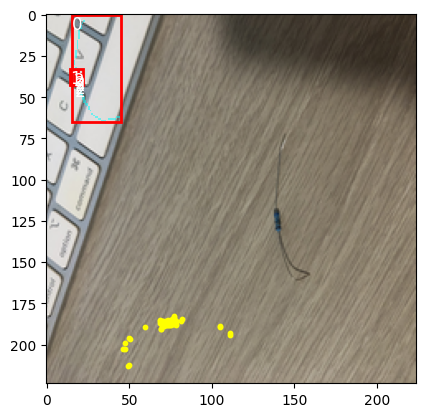

<ipython-input-14-915f76c643d0>:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  target = {'boxes': torch.tensor(boxes, dtype=torch.float32), 'labels': torch.tensor(labels, dtype=torch.int64), 'masks': torch.tensor(masks, dtype=torch.uint8)}


dims 4032 3024 0.05555555555555555 0.07407407407407407 224 224
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904


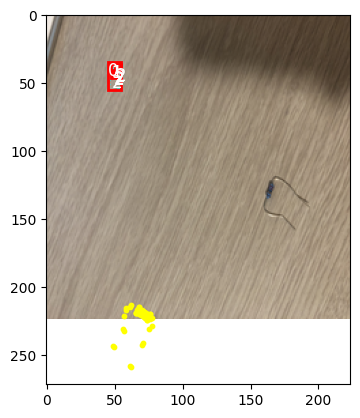

dims 4032 3024 0.05555555555555555 0.07407407407407407 224 224
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904


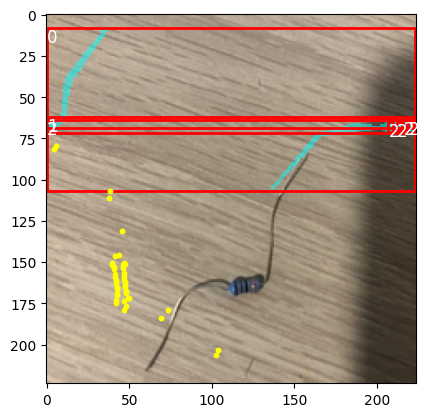

dims 4032 3024 0.05555555555555555 0.07407407407407407 224 224
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904


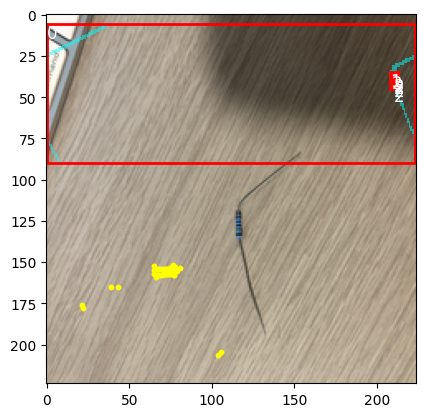

dims 410 705 0.5463414634146342 0.3177304964539007 224 224


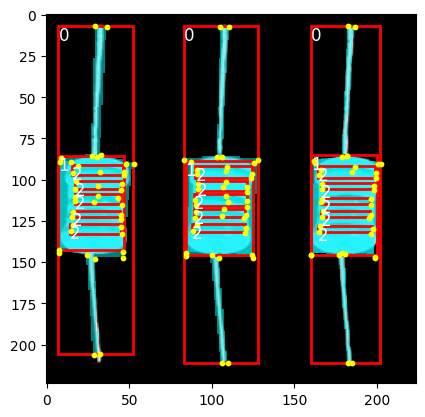

dims 4032 3024 0.05555555555555555 0.07407407407407407 224 224
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904
offsets: -1400 -1904


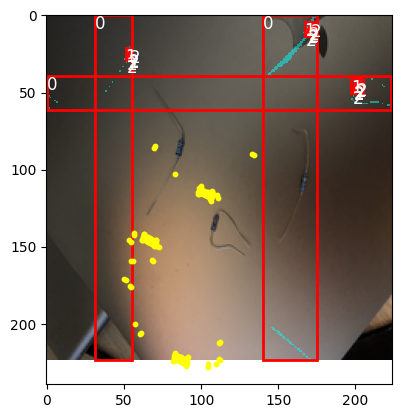

KeyboardInterrupt: ignored

In [21]:
model.to(device)
for epochs in range(num_epochs):
    model.train()
    train_loss = 0
    epoch_loss = 0
    for data in train_dl:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ['masks'] = d[1]['masks'].to(device)
            targ['labels'] = d[1]['labels'].to(device)
            targ['boxes'] = d[1]['boxes'].to(device)
            targets.append(targ)

        loss_dict = model(imgs, targets)
        loss = sum(loss for loss in loss_dict.values())
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("Epoch: {}, Loss: {}".format(epochs, epoch_loss))

    # model.eval()
    # with torch.no_grad():
    #   val_loss = 0
    #   for val_batch in val_dl:
    #       imgs = [data[0].to(device) for data in val_batch]
    #       targets = [data[1] for data in val_batch]

    #       val_targets = []
    #       for t in targets:
    #           val_targets.append({k: v.to(device) for k, v in t.items()})

    #       val_outputs = model(imgs, val_targets)
    #       print('vo', val_outputs)
    #       for output in val_outputs:
    #           loss_components = [v.item() for v in output.values() if v.numel() == 1]
    #           print('lc', loss_components)
    #           val_loss += sum(loss_components)


    #   val_loss /= len(val_dl)

    #   print(f"Epoch: {epochs}, Training Loss: {train_loss / len(train_dl)}, Validation Loss: {val_loss}")



In [ ]:
dataloader = test_dl

model.eval()

data = next(iter(dataloader))

img, _ = data[0][0].to(device), data[0][1]

Filtered Labels: ['Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Body', 'Resistor Bod

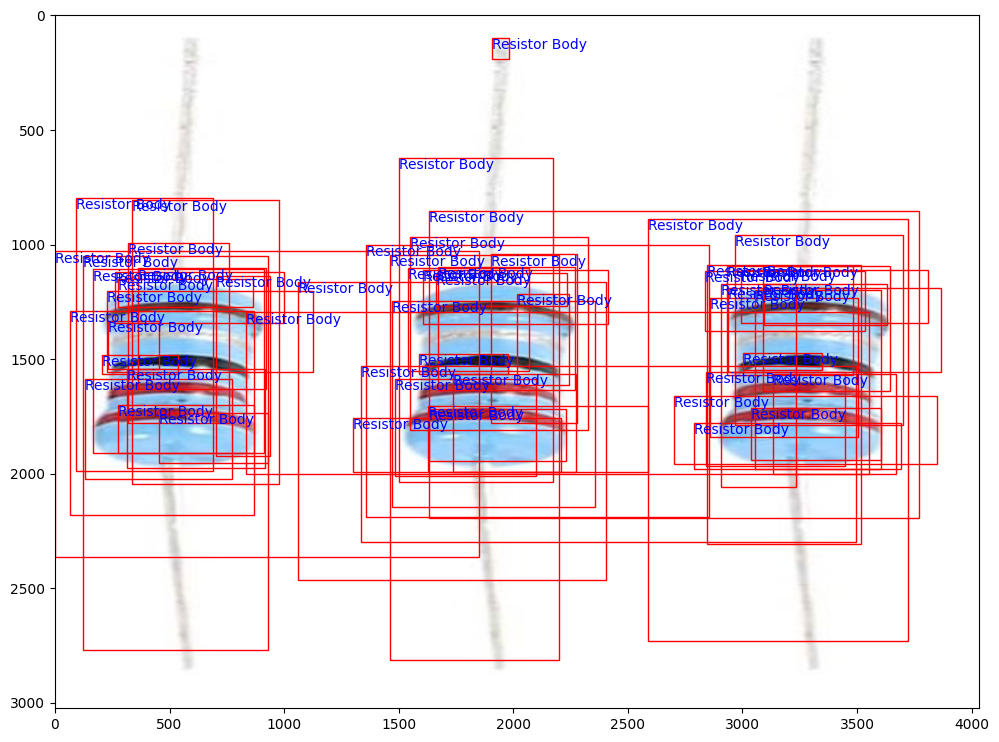

In [ ]:
model.eval()
with torch.no_grad():
    output = model([img.to(device)])

threshold = 0.4
filtered_boxes = []
filtered_labels = []

for score, label, box in zip(output[0]["scores"], output[0]["labels"], output[0]["boxes"]):
    if score > threshold:
        filtered_boxes.append(box)
        filtered_labels.append(label_name_mapping[label.item()])

print("Filtered Labels:", filtered_labels)
print("Filtered Scores:", [score.item() for score in output[0]["scores"] if score > threshold])

image_np = img.cpu().numpy().transpose(1, 2, 0)

fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image_np)

for box, label in zip(filtered_boxes, filtered_labels):
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(box[0], box[1], label, color='blue', fontsize=10, verticalalignment='top')

plt.show()



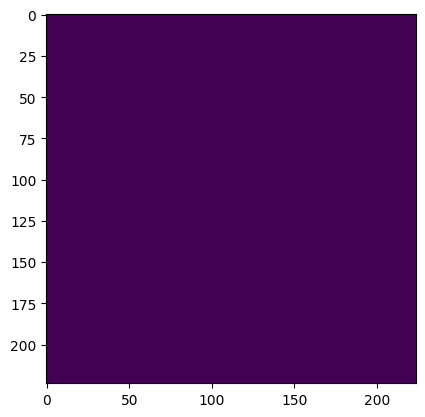

In [ ]:
import cv2
import numpy as np

def sobel_edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=5)
    sobel = cv2.addWeighted(np.absolute(sobelx), 0.5, np.absolute(sobely), 0.5, 0)
    _, thresh = cv2.threshold(sobel, 200, 255, cv2.THRESH_BINARY)
    return thresh

# for box, label in zip(boxes, labels):
#     if label == 'Color':
#         x = int(box[0])
#         y = int(box[1])
#         w = int(box[2] - box[0])
#         h = int(box[3] - box[1])
#         roi = image_np[y:y+h, x:x+w]
#         roi = cv2.resize(roi, (224, 224))
#         roi = sobel_edge_detection(roi)
#         plt.imshow(roi)
#         plt.show()
#         break

for box, label in zip(boxes.cpu(), label_names):
    if label == 'Color':
        x = int(box[0])
        y = int(box[1])
        w = int(box[2] - box[0])
        h = int(box[3] - box[1])
        roi = image_np[y:y+h, x:x+w]
        roi = cv2.resize(roi, (224, 224))
        roi = sobel_edge_detection(roi)
        plt.imshow(roi)
        plt.show()
        break